## Midterm Activity 1
### Feature Selection
> Due Date: June 21, 2025
- Dominguez, Harry Jr.
- Lapig, Cazandra Jae

## Exploring Feature Selection

In [824]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

data = pd.read_csv("data/train.csv")
X = data.iloc[:, 0:20]  # Independent columns
y = data.iloc[:, -1]  # Target column i.e price range

# Apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  # Naming the dataframe columns

print(featureScores.nlargest(10, 'Score'))  # Print 10 best features

            Specs          Score
13            ram  931267.519053
11      px_height   17363.569536
0   battery_power   14129.866576
12       px_width    9810.586750
8       mobile_wt      95.972863
6      int_memory      89.839124
15           sc_w      16.480319
16      talk_time      13.236400
4              fc      10.135166
14           sc_h       9.614878


[0.0607873  0.0201292  0.03373948 0.0197178  0.03302779 0.01823232
 0.03521847 0.03322937 0.03630269 0.03379413 0.03359218 0.04719865
 0.04987396 0.3909555  0.03362416 0.03452799 0.03421869 0.01416418
 0.01790782 0.01975833]


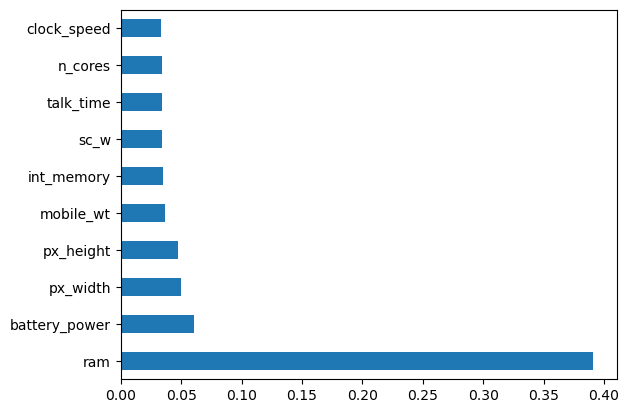

In [825]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

X = data.iloc[:, 0:20]  # Independent columns
y = data.iloc[:, -1]  # Target column i.e price range
model = ExtraTreesClassifier()
model.fit(X, y)
print(model.feature_importances_)  # Use inbuilt class feature_importances of tree based classifiers

# Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

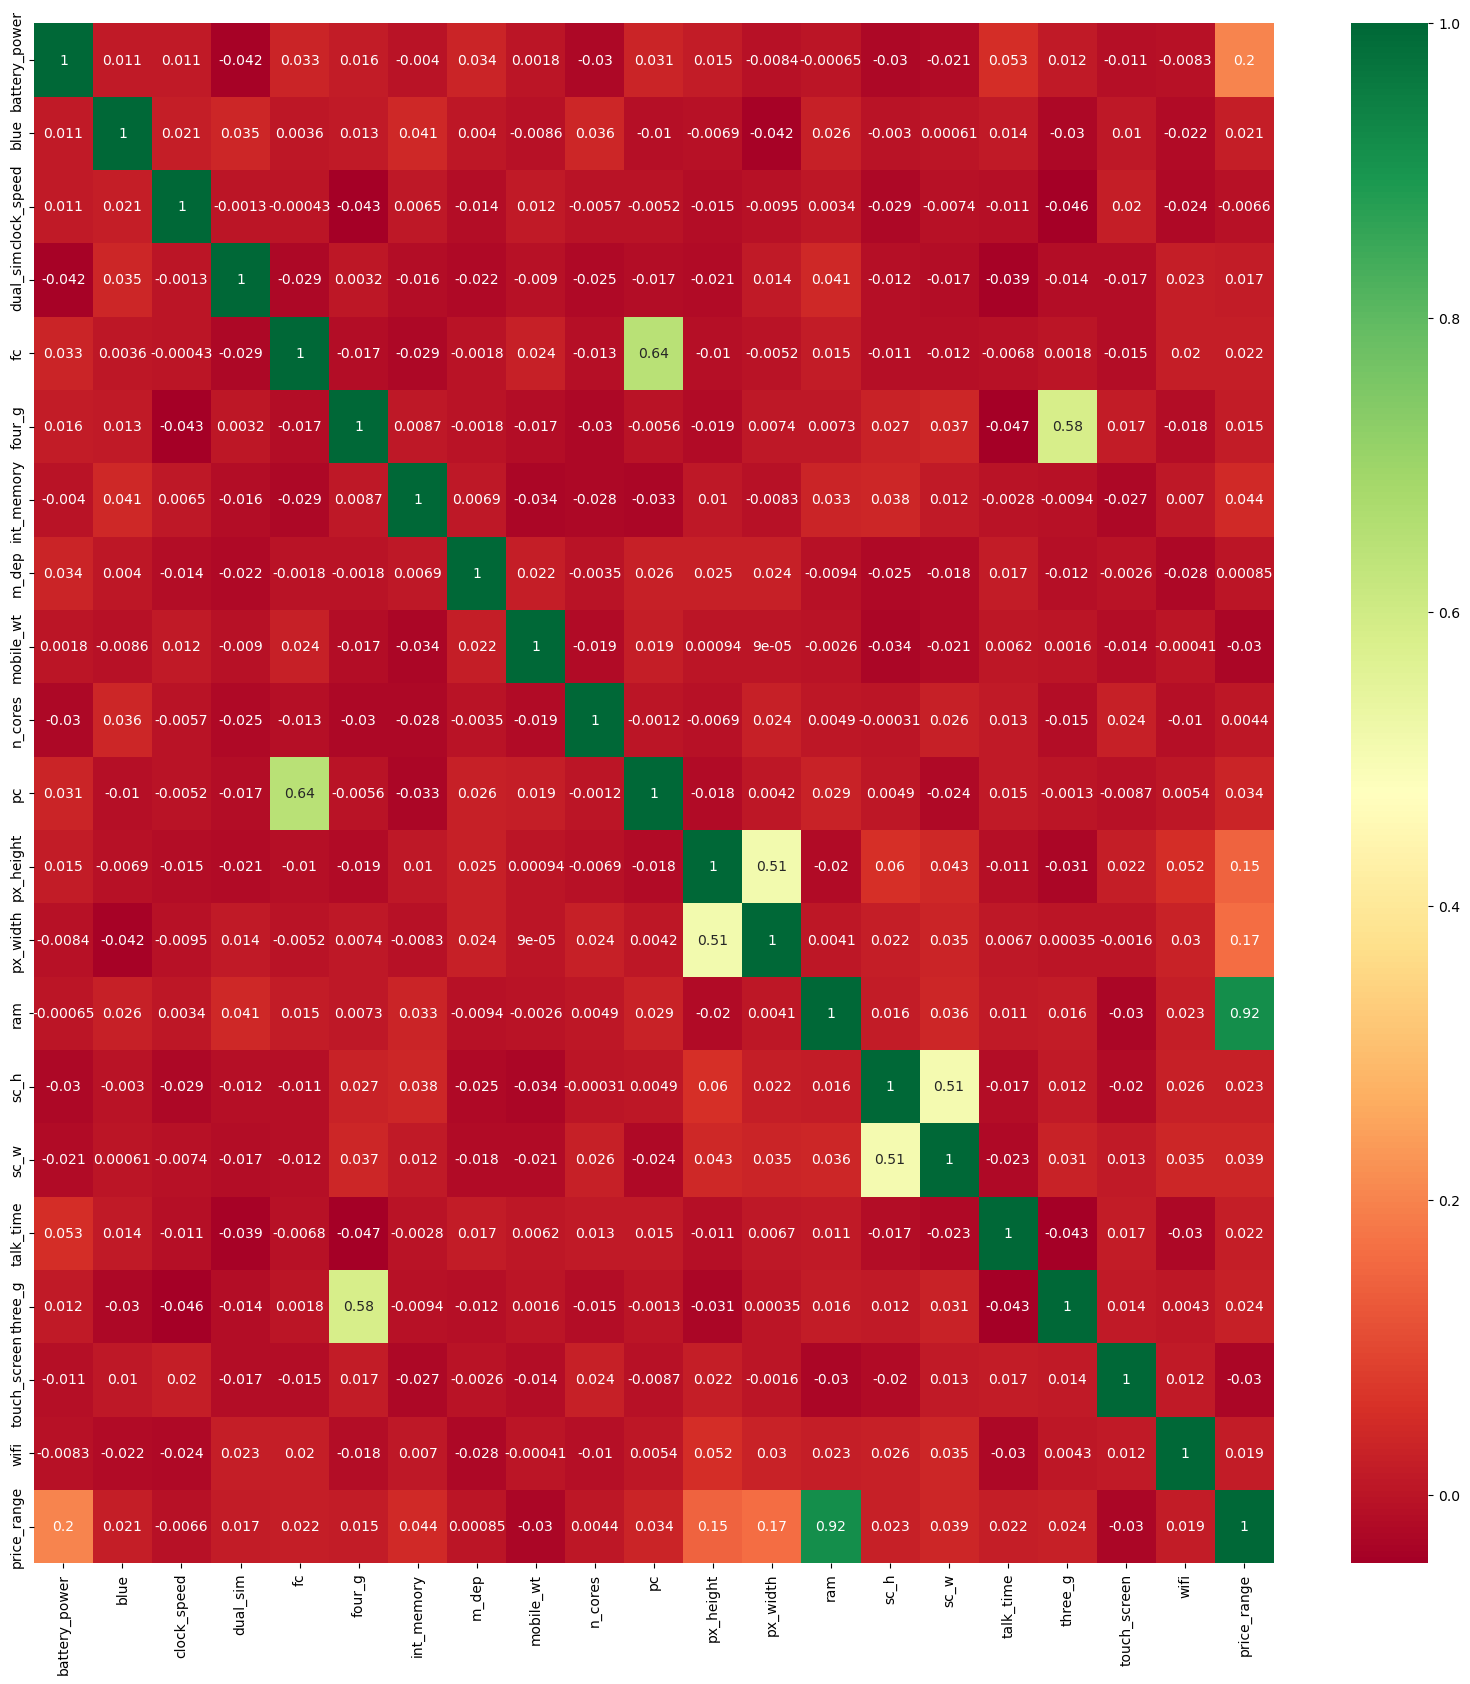

In [826]:
import seaborn as sns

X = data.iloc[:, 0:20]  # Independent columns
y = data.iloc[:, -1]  # Target column i.e price range

# Get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20, 20))

# Plot heat map
g = sns.heatmap(data[top_corr_features].corr(), annot=True, cmap="RdYlGn")

## Classification Model Development

### Data Exploration
- Check the dimensions of the Dataset
- Check for missing values
- Get summary of statistics

In [827]:
import pandas as pd

np.random.seed(10)

# Load dataset
glass = pd.read_csv('data/glass.csv')

# Initial inspection
print("Data shape:", glass.shape)

Data shape: (214, 11)


In [828]:
# Check Skewness of each feature
features = glass.columns[1:-1]
skewness = glass[features].skew().sort_values(ascending=False)
"""
    Skewness < 0.5: Close to symmetric
    0.5 ≤ Skewness < 1: Moderately skewed
    Skewness ≥ 1: Highly skewed
"""
print("\nSkewness Coefficients:\n", skewness)
print("\nClass distribution:\n", glass['type'].value_counts().sort_index())


Skewness Coefficients:
 K     6.551648
Ba    3.416425
Ca    2.047054
Fe    1.754327
RI    1.625431
Al    0.907290
Na    0.454181
Si   -0.730447
Mg   -1.152559
dtype: float64

Class distribution:
 type
1    70
2    76
3    17
5    13
6     9
7    29
Name: count, dtype: int64


### Data Preprocessing
- Remove ID Number column
- Standardization happens during Cross Evaluation

In [829]:
# Drop idno column
glass_processed = glass.drop(columns=['idno'])

feature_names = glass_processed.drop(labels=['type'], axis=1).columns.tolist()

### Model Training
Pipeline (8 Folds):
- Split data (80/20)
- Standardize Data
- Select Features
- Train and Evaluate

In [830]:
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier

# 2. Cross-Validation Setup
n_splits = 8
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=10)
X, y = glass_processed.drop(labels=["type"], axis=1), glass['type']


In [831]:
from sklearn.preprocessing import StandardScaler

# All Features Model
model = ImbPipeline([
    ('scaler', StandardScaler()),
    ('model', GaussianNB())
])

scores = cross_validate(
    model, X, y, cv=cv, scoring=('accuracy', 'recall_macro', 'f1_macro')
)
results = pd.DataFrame({'Feature Selection': ['All Features'],
                            'Accuracy': [np.mean(scores['test_accuracy'])],
                            'Recall': [np.mean(scores['test_recall_macro'])],
                            'F1-Score': [np.mean(scores['test_f1_macro'])],
                            'Selected Features': [feature_names]
                            })
results

,Feature Selection,Accuracy,Recall,F1-Score,Selected Features
0,All Features,0.414886,0.439005,0.399524,"[RI, Na, Mg, Al, Si, K, Ca, Ba, Fe]"


In [832]:
from sklearn.feature_selection import VarianceThreshold, f_classif

# Univariate Model
model = ImbPipeline([
    ('scaler', StandardScaler()),
    ('variance', VarianceThreshold(threshold=0.01)),
    ('kbest', SelectKBest(score_func=f_classif, k=5)),
    ('model', GaussianNB())
])

scores = cross_validate(
    model, X, y, cv=8, scoring=('accuracy', 'recall_macro', 'f1_macro')
)

model.fit(X, y)
kbest = model.named_steps['kbest']
variance = model.named_steps['variance']
mask = variance.get_support()
selected_uni = np.array(feature_names)[mask][kbest.get_support()].tolist()

temp_result = pd.DataFrame({'Feature Selection': ['Univariate Selection'],
                            'Accuracy': [np.mean(scores['test_accuracy'])],
                            'Recall': [np.mean(scores['test_recall_macro'])],
                            'F1-Score': [np.mean(scores['test_f1_macro'])],
                            'Selected Features': [selected_uni]
                            })

scores, columns = pd.DataFrame(kbest.scores_), pd.DataFrame(X.columns)
feature_scores = pd.concat([columns, scores], axis=1)
feature_scores.columns = ['Attribute', 'Score']
results = pd.concat([results, temp_result])
print("Scores of Top 5 Features\n", feature_scores.nlargest(5, 'Score'))
temp_result

Scores of Top 5 Features
   Attribute      Score
2        Mg  65.544521
7        Ba  38.974602
3        Al  35.726676
1        Na  28.548019
5         K   8.748128


,Feature Selection,Accuracy,Recall,F1-Score,Selected Features
0,Univariate Selection,0.433939,0.480035,0.424857,"[Na, Mg, Al, K, Ba]"


[0.13706345 0.08885004 0.18024975 0.13359617 0.08618453 0.10807577
 0.13190624 0.07891503 0.05515902]


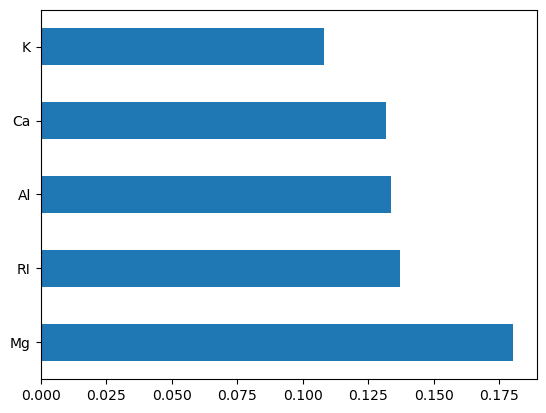

,Feature Selection,Accuracy,Recall,F1-Score,Selected Features
0,Feature Importance Selection,0.429487,0.430093,0.317847,"[K, Ca, Al, RI, Mg]"


In [833]:
# Feature Importance Model
class ImportanceSelector:
    def __init__(self, n_features=5):
        self.n_features = n_features
        self.selected_indices_ = None
        self.feature_importances_ = None

    def fit(self, X, y):
        rf = ExtraTreesClassifier(random_state=10)
        rf.fit(X, y)
        self.feature_importances_ = rf.feature_importances_
        self.selected_indices_ = np.argsort(rf.feature_importances_)[-self.n_features:]
        return self

    def transform(self, X):
        return X[:, self.selected_indices_]


model = ImbPipeline([
    ('scaler', StandardScaler()),
    ('selector', ImportanceSelector(n_features=5)),
    ('model', GaussianNB())
])
scores = cross_validate(
    model, X, y, cv=8, scoring=('accuracy', 'recall_macro', 'f1_macro')
)
model.fit(X, y)
selector = model.named_steps['selector']
selected_impor = np.array(feature_names)[selector.selected_indices_].tolist()
temp_result = pd.DataFrame({'Feature Selection': ['Feature Importance Selection'],
                            'Accuracy': [np.mean(scores['test_accuracy'])],
                            'Recall': [np.mean(scores['test_recall_macro'])],
                            'F1-Score': [np.mean(scores['test_f1_macro'])],
                            'Selected Features': [selected_impor]
                            })

print(selector.feature_importances_)
feat_importances = pd.Series(selector.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()
results = pd.concat([results, temp_result])
temp_result

,Feature Selection,Accuracy,Recall,F1-Score,Selected Features
0,Correlation Selection,0.237892,0.309664,0.199998,"[Mg, Al, Ba, Na, Fe]"


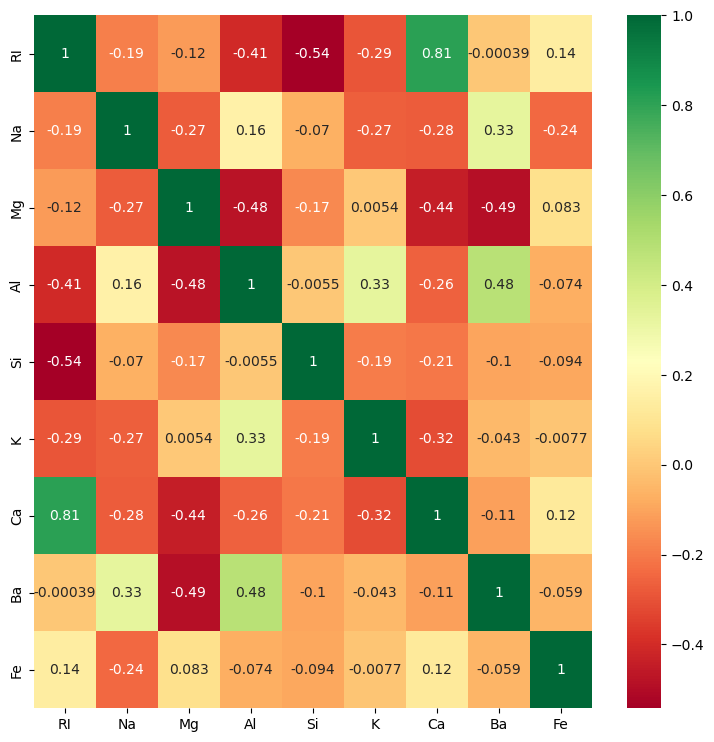

In [846]:
# Correlation Model
class CorrelationSelector:
    def __init__(self, n_features=5):
        self.n_features = n_features
        self.selected_indices_ = None
        self.selected_features_ = None

    def fit(self, X, y):
        # Create DataFrame with features and encoded target
        df = pd.DataFrame(X)
        df['target'] = pd.Series(y).astype('category').cat.codes

        corr_series = df.corr()['target'].abs().drop('target')

        self.selected_indices_ = corr_series.nlargest(self.n_features).index

        if hasattr(X, 'columns'):
            self.selected_features_ = X.columns[self.selected_indices_].tolist()

        return self

    def transform(self, X):
        return X[:, self.selected_indices_]


model = ImbPipeline([
    ('scaler', StandardScaler()),
    ('selector', CorrelationSelector(n_features=5)),
    ('model', GaussianNB())
])
scores = cross_validate(
    model, X, y, cv=8, scoring=('accuracy', 'recall_macro', 'f1_macro')
)
model.fit(X, y)
selector = model.named_steps['selector']
selected_corr = np.array(feature_names)[selector.selected_indices_].tolist()
temp_result = pd.DataFrame({'Feature Selection': ['Correlation Selection'],
                            'Accuracy': [np.mean(scores['test_accuracy'])],
                            'Recall': [np.mean(scores['test_recall_macro'])],
                            'F1-Score': [np.mean(scores['test_f1_macro'])],
                            'Selected Features': [selected_corr]
                            })

plt.figure(figsize=(9, 9))
corrmat = X.corr()
top_corr_features = corrmat.index
g=sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")

results = pd.concat([results, temp_result])
temp_result

In [835]:
# Final Results
results

,Feature Selection,Accuracy,Recall,F1-Score,Selected Features
0,All Features,0.414886,0.439005,0.399524,"[RI, Na, Mg, Al, Si, K, Ca, Ba, Fe]"
0,Univariate Selection,0.433939,0.480035,0.424857,"[Na, Mg, Al, K, Ba]"
0,Feature Importance Selection,0.429487,0.430093,0.317847,"[K, Ca, Al, RI, Mg]"
0,Correlation Selection,0.237892,0.309664,0.199998,"[Mg, Al, Ba, Na, Fe]"
